# Q1: Sampling a 2d target

In [2]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import pandas as pd

## 1.1 Direct sampling
insert derivation of transformation and sampling here

In [5]:
def sample_r(k, N=1):
    a = k/2
    b = 1/2
    return stats.gamma.rvs(a, scale=1/b, size=N)

def sample_theta(N=1):
    return stats.uniform.rvs(scale=2*np.pi, size=N)

In [7]:
def direct_sampling(k, N=100000):
    rs = sample_r(k=k, N=N)
    ts = sample_theta(N=N)

    xs = rs * np.cos(ts)
    ys = rs * np.sin(ts)

    return xs, ys

In [43]:
def target_density(x, y, k):
    r2 = x**2 + y**2
    r = np.sqrt(r2)
    return (r2)**(k / 4 - 1) * np.exp(-r / 2)

def get_target_density_samples(k):
    x = np.linspace(-2*k, 2*k, 300)
    y = np.linspace(-2*k, 2*k, 300)
    X, Y = np.meshgrid(x, y)
    z = target_density(X, Y, k)
    z /= z.sum()
    return X, Y, z

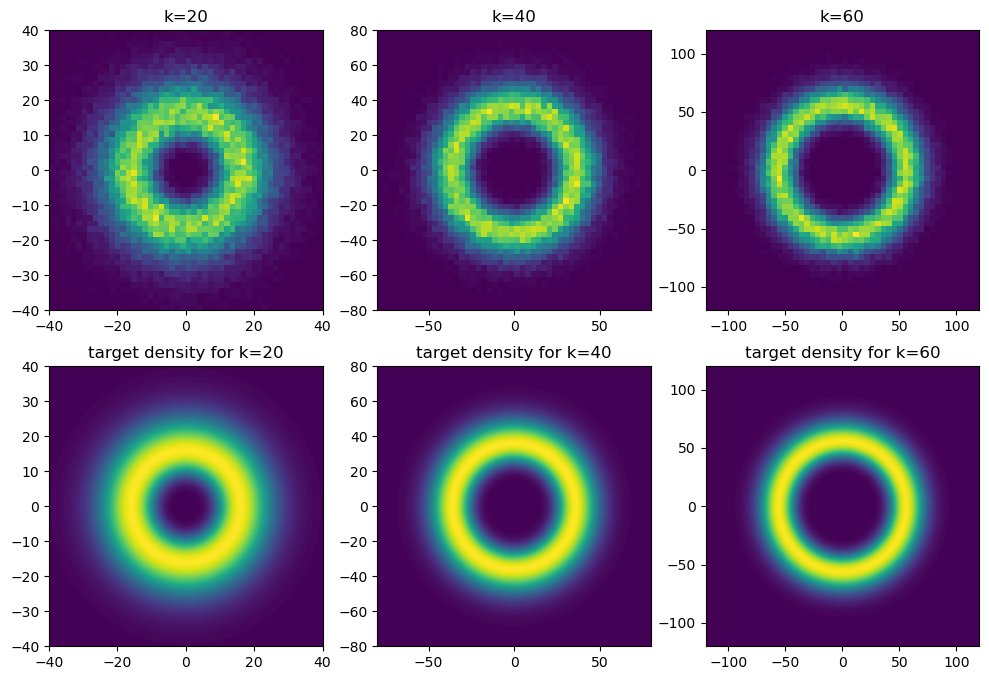

In [380]:
ks = [20, 40, 60]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))

for i, k in enumerate(ks):
    x, y = direct_sampling(k=k)
    ax[0][i].hist2d(x, y, range=[[-2*k, 2*k], [-2*k, 2*k]], bins=50, cmap='viridis')
    ax[0][i].set_title(f'k={k}')

    X, Y, Z = get_target_density_samples(k=k)
    ax[1][i].contourf(X, Y, Z, levels=100)
    ax[1][i].set_title(f'target density for k={k}')
    
plt.show()

## 1.2 Metropolis-Hastings sampler

In [348]:
def target_distribution(x: float, y: float, k: int, epsilon: float = 10e-9) -> float:
    return max((x**2 + y**2)**(k/4 - 1) * np.exp(-(np.sqrt(x**2 + y**2)) / 2), epsilon)

In [350]:
def metropolis_hastings_random_walk(k, N=100000, sigma=1, target_dist=target_distribution):
    x_samples, y_samples = [], []
    x, y = 0, 0
    accepted_samples = 0
    
    progress_bar = tqdm(total=N, leave=True)
    while len(x_samples) < N:
        x1 = stats.norm.rvs(loc=x, scale=sigma)
        y1 = stats.norm.rvs(loc=y, scale=sigma)

        a = min(1, (target_dist(x1, y1, k=k)) / (target_dist(x, y, k=k)))
        
        if stats.uniform.rvs() < a:
            x, y = x1, y1
            accepted_samples += 1
            
        x_samples.append(x)
        y_samples.append(y)
        progress_bar.update(1)

    # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")
            
    return np.array(x_samples), np.array(y_samples)

### identifying burn in for each k

In [369]:
mh_xs, mh_ys = [], []
for k in ks:
    x, y = metropolis_hastings_random_walk(k=k, sigma=(0.7*k), N=100000)
    mh_xs.append(x)
    mh_ys.append(y)

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.49


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.38


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.33


We tune $\sigma$ by hand to reach a target acceptance rate within the range $(0.3, 0.5)$. This gives us an indication that the proposal sampler explores all if the target domain and also has good exploitation of high density areas in our target distribution.

It makes sense to scale sigma by $k$ as this correlates to the radius of the distribution which also scales roughly linearly according to $k$ (a can be seen in the direct sampling plots). We want a $k$ that allows us to jump from one side of the circle to the other with 

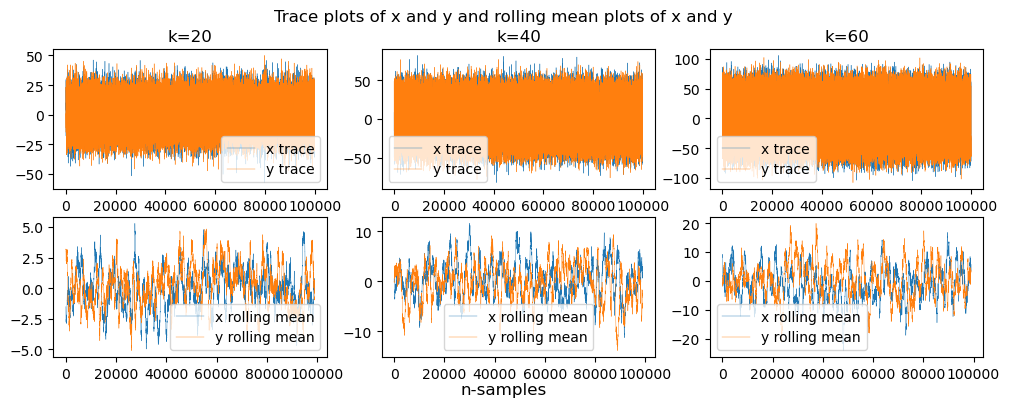

In [372]:
def moving_window_mean(data: list, window_size=100):
    return pd.Series(data).rolling(window=window_size).mean().to_numpy()[window_size-1:]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 4))

for i, (k, x, y) in enumerate(zip(ks, mh_xs, mh_ys)):
    ax[0][i].plot(x, label='x trace', lw=0.3)
    ax[0][i].plot(y, label='y trace', lw=0.3)
    ax[0][i].set_title(f"k={k}")
    ax[0][i].legend()
    
    x_running_mean = moving_window_mean(x.flatten().tolist(), window_size=1000)
    y_running_mean = moving_window_mean(y.flatten().tolist(), window_size=1000)
    ax[1][i].plot(x_running_mean, label='x rolling mean', lw=0.3)
    ax[1][i].plot(y_running_mean, label='y rolling mean', lw=0.3)
    ax[1][i].legend()
    
fig.supxlabel('n-samples')
fig.suptitle('Trace plots of x and y and rolling mean plots of x and y')
plt.show()

We can see that starting at $(0, 0)$, there is virtually no burn-in period. Immediately the samples randomly walk mean a mean of approximately 0 in both x and y dimensions.

We will still discard the first 10% (10,000) of samples for good measure.

k=20, no. of burn in samples removed: 10000, no. of samples remaining: 90000
k=40, no. of burn in samples removed: 10000, no. of samples remaining: 90000
k=60, no. of burn in samples removed: 10000, no. of samples remaining: 90000


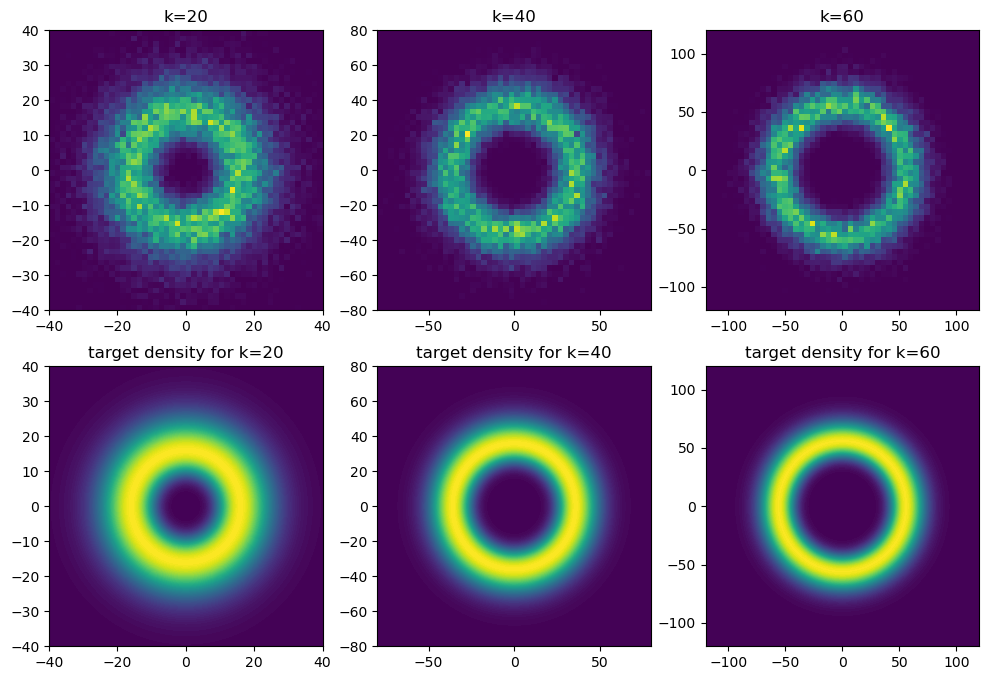

In [384]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
burnin_percentage = 0.1

for i, (k, x, y) in enumerate(zip(ks, mh_xs, mh_ys)):
    
    burnin = int(np.floor(burnin_percentage * len(x)))
    print(f'k={k}, no. of burn in samples removed: {burnin}, no. of samples remaining: {len(x) - burnin}')
    
    ax[0][i].hist2d(x[burnin:], y[burnin:], bins=50, cmap='viridis', range=[[-2*k, 2*k], [-2*k, 2*k]])
    ax[0][i].set_title(f"k={k}")

    X, Y, Z = get_target_density_samples(k=k)
    ax[1][i].contourf(X, Y, Z, levels=100)
    ax[1][i].set_title(f'target density for k={k}')
    
plt.show()

## 1.3 Metropolis-adjusted Langevin algorithm (MALA)

In [386]:
def gradient_log_target(x, y, k, epsilon=10e-9):
    r = np.sqrt(np.maximum(x**2 + y**2, epsilon))
    factor = (k / 4 - 1) * 2 / r - 1/2
    def grad(v):
        nonlocal factor, r
        return v/r * factor
    return grad(x), grad(y)

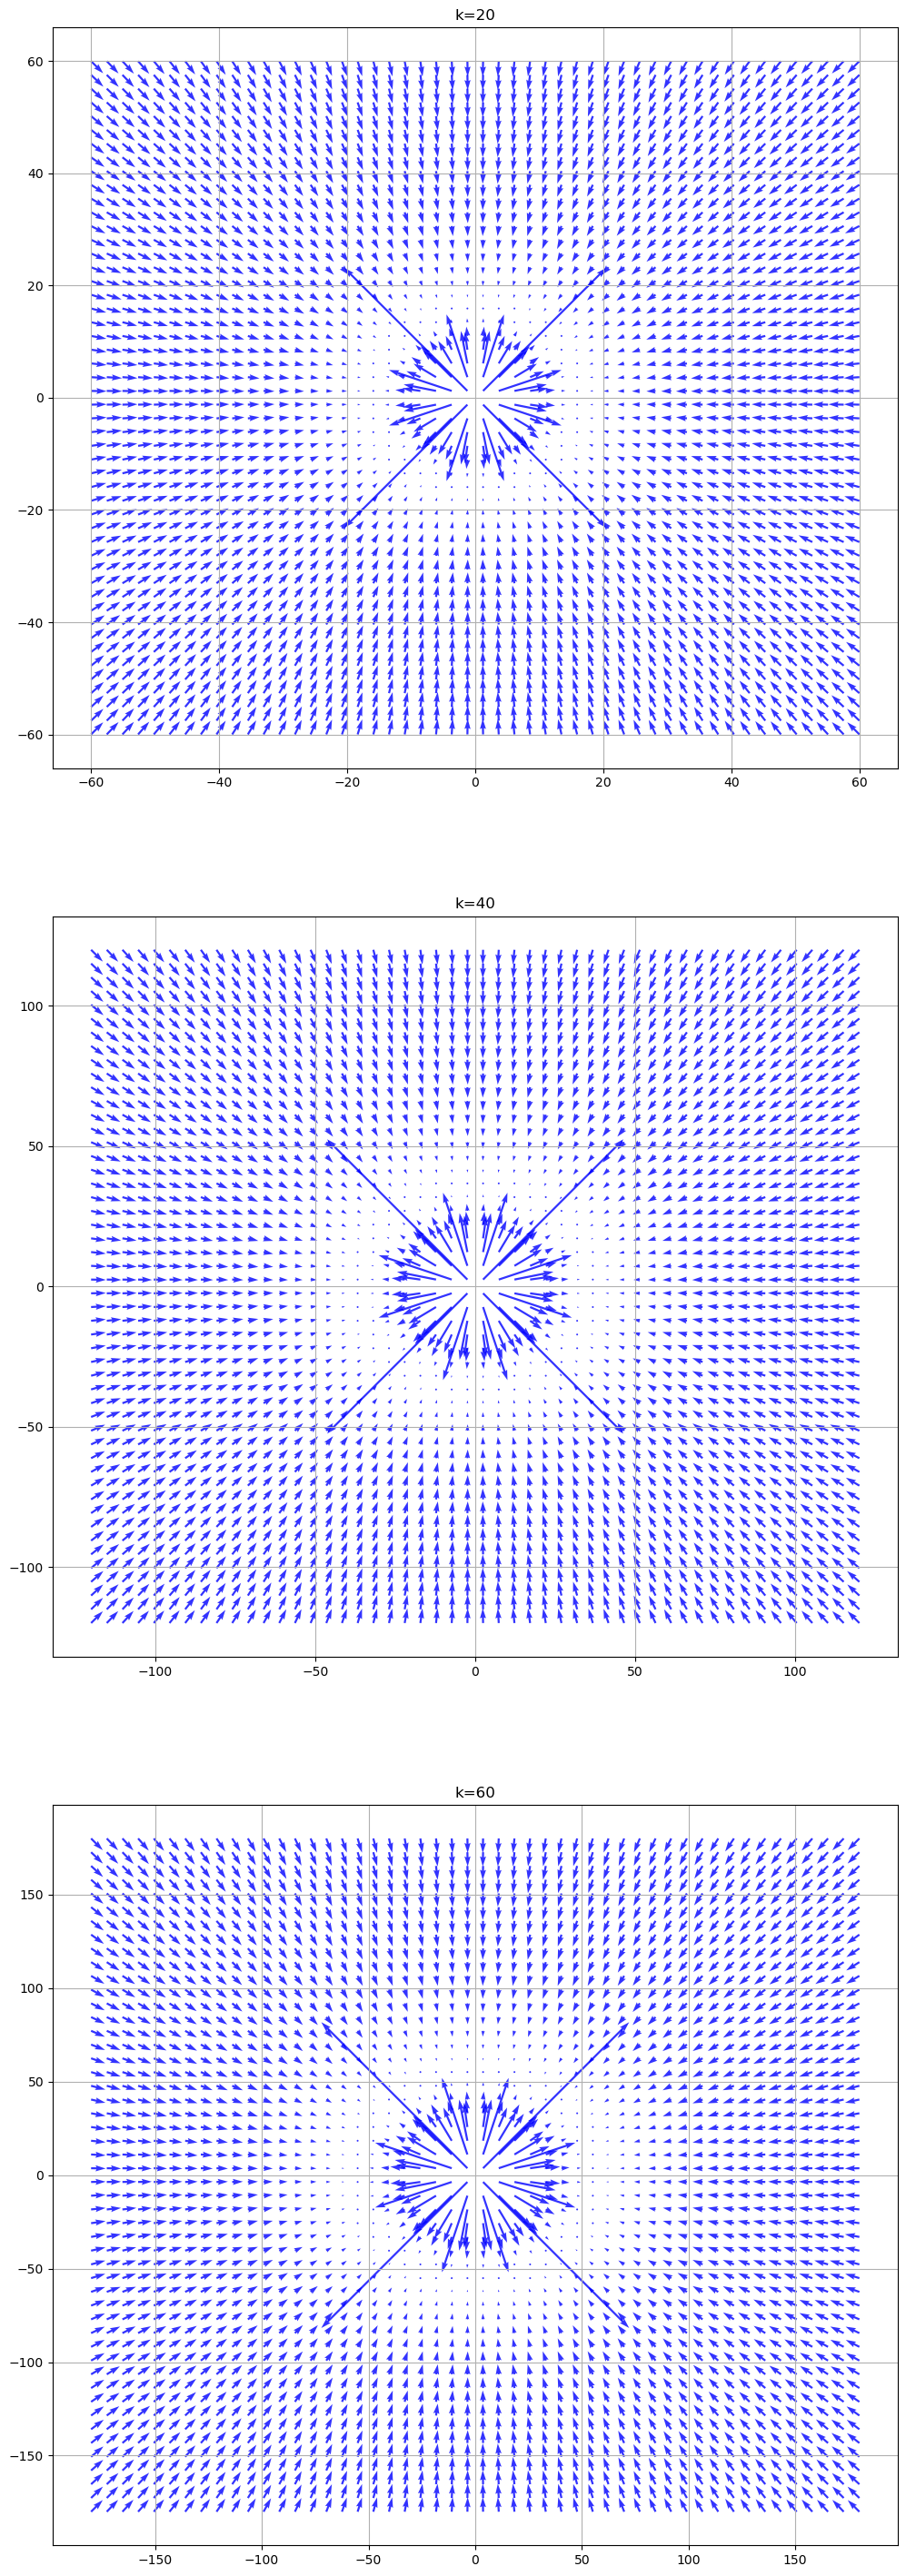

In [604]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(12, 36))
precision = 50
for i, k in enumerate(ks):
    ax[i].set_title(f"k={k}")
    
    x = np.linspace(-3*k, 3*k, precision)
    y = np.linspace(-3*k, 3*k, precision)
    x_mesh, y_mesh = np.meshgrid(x, y)
    
    gx, gy = gradient_log_target(x_mesh, y_mesh, k)
    
    ax[i].quiver(x_mesh, y_mesh, gx, gy, scale=20, color='blue', alpha=0.8)
    ax[i].grid(True)

plt.show()

In [609]:
def target_distribution_vector(v: np.array, k: int, epsilon: float = 10e-9) -> float:
    return max(np.sum(v ** 2)**(k/4 - 1) * np.exp(-(np.sqrt(np.sum(v ** 2))) / 2), epsilon)
    
def gradient_log_target_vector(v, k, epsilon=1e-9):
    r_sq = np.sum(v**2) + epsilon
    factor = (k / 4 - 1) * 2 / r_sq
    return (factor - 1 / (2 * np.sqrt(r_sq))) * v

# def gradient_log_target_vector(v, k, epsilon=1e-9):
#     r = np.sqrt(np.maximum(v**2, epsilon))
#     factor = (k / 4 - 1) * 2 / r - 1/2
#     return v/r * factor
    
def langevin_proposal(v, k, step_size, 
                      grad_log_target = gradient_log_target_vector):
    g = grad_log_target(v, k)
    s = step_size
    return np.random.multivariate_normal(mean=v + (s * g), cov=2 * s * np.identity(2))

def langevin_pdf(v1, v, k, step_size, 
                 grad_log_target = gradient_log_target_vector):
    # probability of going from x -> x1 given langevin proposals
    g = grad_log_target(v, k)
    s = step_size
    return stats.multivariate_normal.pdf(v1, mean=v + (s * g), cov=2 * s * np.identity(2))

In [579]:
def metropolis_adjusted_langevin(k, step_size, N=100000,
                                 target_dist = target_distribution_vector, 
                                 grad_log_target = gradient_log_target_vector):
    x_samples, y_samples = [], []
    v = np.array([0, 0])
    accepted_samples = 0

    progress_bar = tqdm(total=N, leave=True)
    while len(x_samples) < N:
        v1 = langevin_proposal(v, k, step_size)

        a = min(
            1,
            (target_dist(v1, k=k) * langevin_pdf(v, v1, k, step_size, grad_log_target=grad_log_target)) /
            (target_dist(v, k=k) * langevin_pdf(v1, v, k, step_size, grad_log_target=grad_log_target))
        )
        
        if stats.uniform.rvs() < a:
            v = v1
            accepted_samples += 1
            
        x_samples.append(v[0])
        y_samples.append(v[1]) 
        progress_bar.update(1)

    # Compute acceptance rate
    acceptance_rate = accepted_samples / N
    print(f"Acceptance rate: {acceptance_rate:.2f}")
            
    return np.array(x_samples), np.array(y_samples)

In [581]:
mhl_xs, mhl_ys = [], []
for k in ks:
    x, y = metropolis_adjusted_langevin(k=k, step_size=4*k)
    mhl_xs.append(x)
    mhl_ys.append(y)

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.54


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.47


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.50


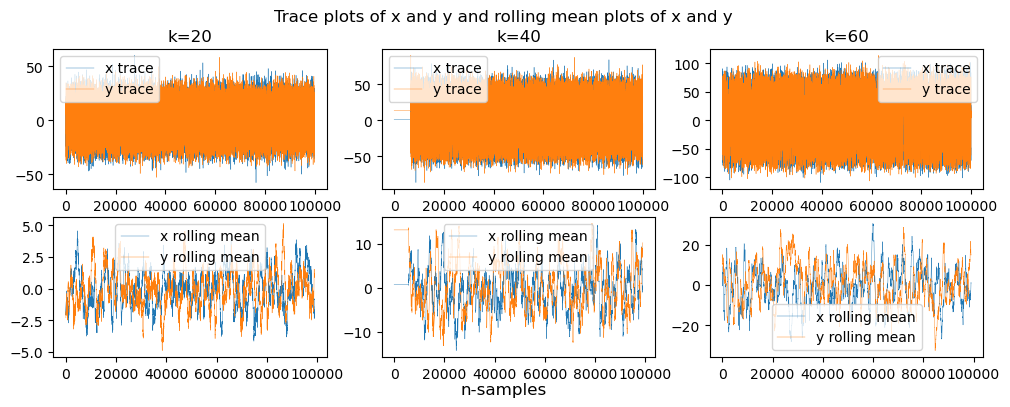

In [583]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 4))

for i, (k, x, y) in enumerate(zip(ks, mhl_xs, mhl_ys)):
    ax[0][i].plot(x, label='x trace', lw=0.3)
    ax[0][i].plot(y, label='y trace', lw=0.3)
    ax[0][i].set_title(f"k={k}")
    ax[0][i].legend()
    
    x_running_mean = moving_window_mean(x.flatten().tolist(), window_size=1000)
    y_running_mean = moving_window_mean(y.flatten().tolist(), window_size=1000)
    ax[1][i].plot(x_running_mean, label='x rolling mean', lw=0.3)
    ax[1][i].plot(y_running_mean, label='y rolling mean', lw=0.3)
    ax[1][i].legend()
    
fig.supxlabel('n-samples')
fig.suptitle('Trace plots of x and y and rolling mean plots of x and y')
plt.show()

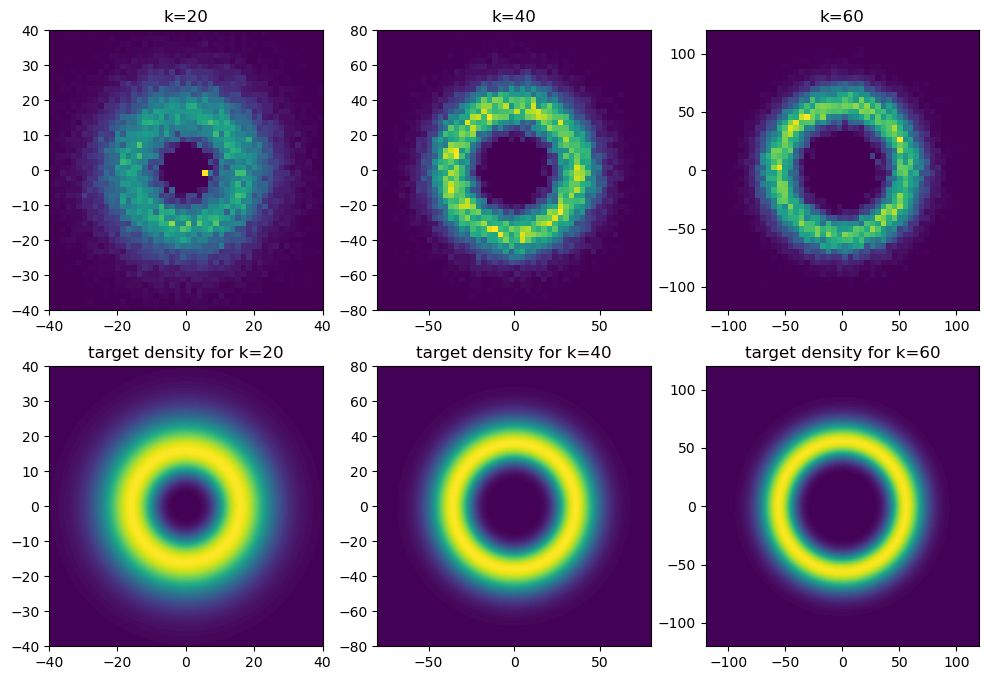

In [584]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
burnin = 10000
for i, (k, x, y) in enumerate(zip(ks, mhl_xs, mhl_ys)):
    ax[0][i].hist2d(x[burnin:], y[burnin:], bins=50, cmap='viridis', range=[[-2*k, 2*k], [-2*k, 2*k]])
    ax[0][i].set_title(f"k={k}")

    X, Y, Z = get_target_density_samples(k=k)
    ax[1][i].contourf(X, Y, Z, levels=100)
    ax[1][i].set_title(f'target density for k={k}')
plt.show()

## 1.4 Implementation of autocorrelation estimator

In [493]:
def autocorrelation(samples: np.array, max_lag=100) -> np.array:
    x_bar = np.mean(samples)
    n = len(samples)
    var = np.var(samples)
    
    # return [COV / CAR for lag in range(1, max_range + 1)]
    return [np.sum(((samples[:n-lag] - x_bar) * (samples[lag:] - x_bar)) / (n - lag)) / var for lag in range(1, max_lag+1)]

### demonstration of autocorrelation estimator

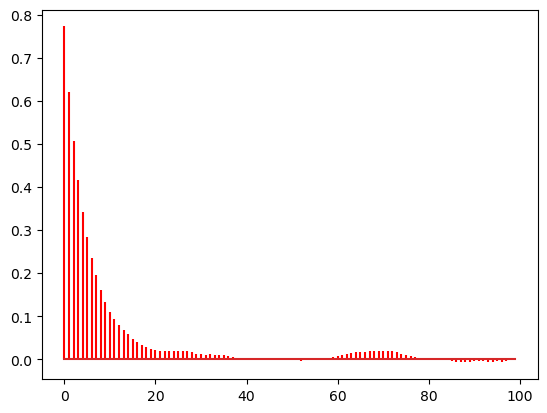

In [496]:
plt.stem(range(100), autocorrelation(mhl_xs[0][burnin:]), linefmt="red", markerfmt=" ")
plt.show()

## 1.5 Computing autocorrelation on each MH sampler for $k=40$, $N=100000$, $lag=100$

In [606]:
k=40
N=100000
max_lag=100

burnin=10000

# rw samples
sigmas = [0.4, 0.8, 1, 1.2, 1.4, 1.8]
rw_samples = [metropolis_hastings_random_walk(k=k, N=N, sigma=s*k) for s in sigmas]

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.54


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.35


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.30


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.25


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.21


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.15


In [607]:
# remove burn in
rw_samples_b = [(x[burnin:], y[burnin:]) for (x, y) in rw_samples]
# calculate autocorrelation
autocorrs = [(autocorrelation(x, max_lag=max_lag), 
              autocorrelation(y, max_lag=max_lag))  
             for (x, y) in rw_samples_b]

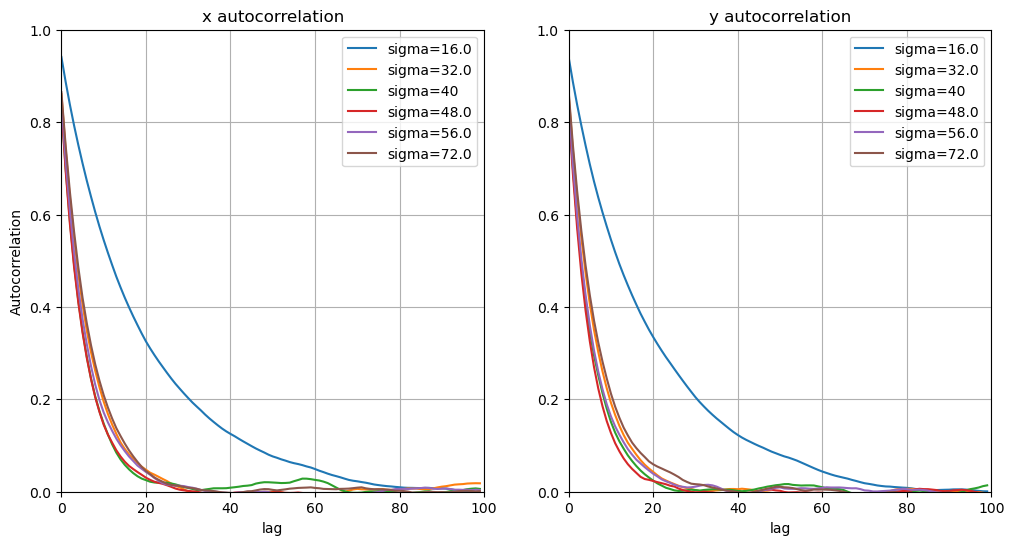

In [608]:
fix, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

for s, (corr_x, corr_y) in zip(sigmas, autocorrs):
    lbl = f'sigma={s*k}'
    
    ax[0].plot(corr_x, label=lbl)
    ax[0].set_xlim(0, 100)
    ax[0].set_ylim(0, 1)
    
    ax[1].plot(corr_y, label=lbl)
    ax[1].set_xlim(0, 100)
    ax[1].set_ylim(0, 1)

ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Autocorrelation')
ax[0].set_xlabel('lag')
ax[1].set_xlabel('lag')
ax[0].set_title('x autocorrelation')
ax[1].set_title('y autocorrelation')
ax[0].grid('lag')
ax[1].grid('lag')
fig.suptitle('he')
plt.show()

In [588]:
# rw samples
steps = [2, 3, 4, 5, 6, 7, 8, 9]
mala_samples = [metropolis_adjusted_langevin(k=k, N=N, step_size=s*k) for s in steps]

  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.91


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.76


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.55


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.50


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.41


  0%|          | 0/100000 [00:00<?, ?it/s]

Acceptance rate: 0.34


In [596]:
# remove burn in
mala_samples_b = [(x[burnin:], y[burnin:]) for (x, y) in mala_samples]
# calculate autocorrelation
mala_autocorrs = [(autocorrelation(x, max_lag=max_lag), 
              autocorrelation(y, max_lag=max_lag))  
             for (x, y) in mala_samples_b]

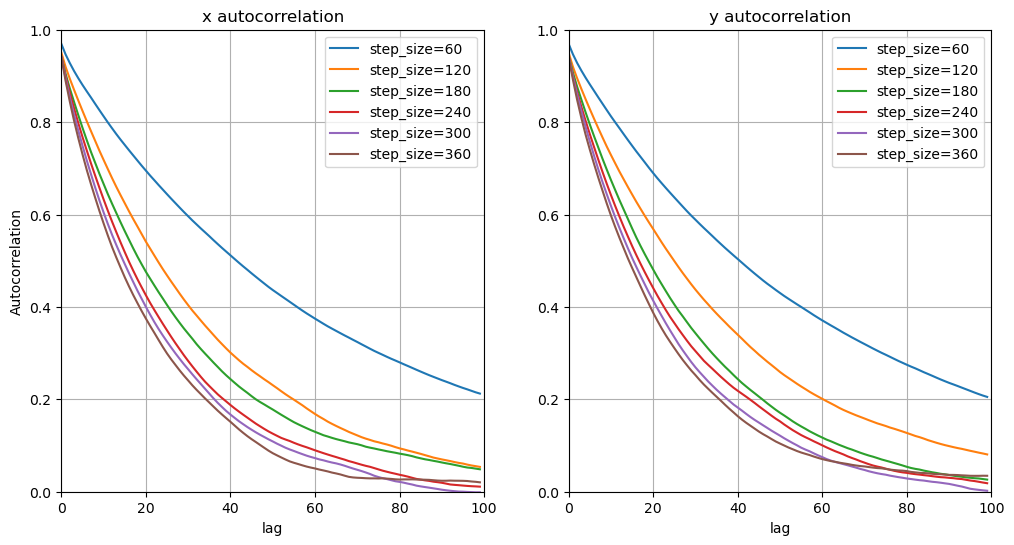

In [598]:
fix, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

for s, (corr_x, corr_y) in zip(steps, mala_autocorrs):
    lbl = f'step_size={s*k}'
    
    ax[0].plot(corr_x, label=lbl)
    ax[0].set_xlim(0, 100)
    ax[0].set_ylim(0, 1)
    
    ax[1].plot(corr_y, label=lbl)
    ax[1].set_xlim(0, 100)
    ax[1].set_ylim(0, 1)

ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Autocorrelation')
ax[0].set_xlabel('lag')
ax[1].set_xlabel('lag')
ax[0].set_title('x autocorrelation')
ax[1].set_title('y autocorrelation')
ax[0].grid('lag')
ax[1].grid('lag')
plt.show()

# Q2: Bayesian Inference with a GMM prior

## 2.1 Exact GMM sampler

In [186]:
def exact_GMM_prior_sampler(m, s_sq, N=10000):
    samples = np.array(
        [
            np.mean([
                stats.multivariate_normal.rvs(mean=mu, cov=s_sq*np.identity(2)) for mu in m
            ], axis=1) 
            for _ in trange(N)
        ]
    )
    return samples[:, 0], samples[:, 1]

In [188]:
m = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
s_sq = 2

x, y = exact_GMM_prior_sampler(m, s_sq)

  0%|          | 0/10000 [00:00<?, ?it/s]

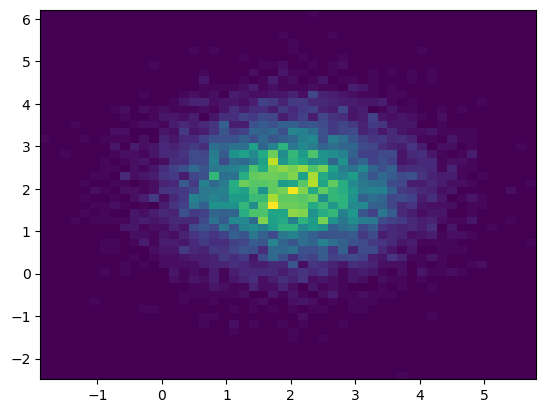

In [189]:
plt.hist2d(x, y, bins=50, cmap='viridis')
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

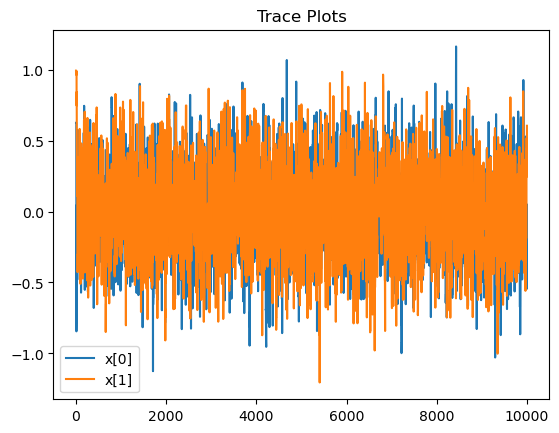

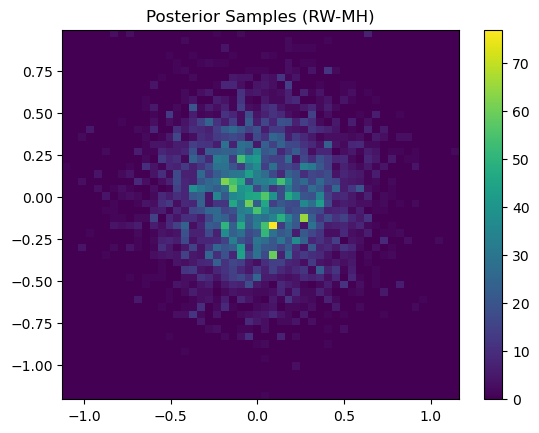

In [202]:
import numpy as np
from scipy.stats import multivariate_normal, norm

# Define the posterior target function p(y|x)p(x)
def log_posterior(x, y, H, sigma_sq, gmm_means, gmm_cov):
    # Likelihood p(y|x)
    log_likelihood = norm.logpdf(y, loc=H @ x, scale=np.sqrt(sigma_sq)).sum()
    
    # Prior p(x): GMM log density
    log_prior = np.log(np.mean([
        multivariate_normal(mean=mu, cov=gmm_cov).pdf(x)
        for mu in gmm_means
    ]))
    
    return log_likelihood + log_prior

# Random Walk Metropolis-Hastings
def rw_mh_sampler(y, H, sigma_sq, gmm_means, gmm_cov, proposal_var, n_samples):
    samples = []
    x_current = np.random.randn(2)  # Initialize randomly
    for _ in trange(n_samples):
        # Propose new x'
        x_proposed = x_current + np.random.normal(0, proposal_var, size=2)
        
        # Compute acceptance probability
        log_accept_prob = (
            log_posterior(x_proposed, y, H, sigma_sq, gmm_means, gmm_cov) -
            log_posterior(x_current, y, H, sigma_sq, gmm_means, gmm_cov)
        )
        accept_prob = min(1, np.exp(log_accept_prob))
        
        # Accept or reject
        if np.random.rand() < accept_prob:
            x_current = x_proposed
        
        samples.append(x_current)
    
    return np.array(samples)

# Parameters
y = 0  # Observed value
H = np.array([1, 1])  # Matrix H
sigma_sq = 2
proposal_var = 0.5  # Tuning parameter for proposal variance
n_samples = 10000

# GMM Prior
gmm_means = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
gmm_cov = 0.1 * np.eye(2)

# Run the sampler
samples = rw_mh_sampler(y, H, sigma_sq, gmm_means, gmm_cov, proposal_var, n_samples)

# Plot trace plots
import matplotlib.pyplot as plt
plt.plot(samples[:, 0], label='x[0]')
plt.plot(samples[:, 1], label='x[1]')
plt.legend()
plt.title("Trace Plots")
plt.show()

# 2D histogram of samples
plt.hist2d(samples[:, 0], samples[:, 1], bins=50, cmap='viridis')
plt.colorbar()
plt.title("Posterior Samples (RW-MH)")
plt.show()


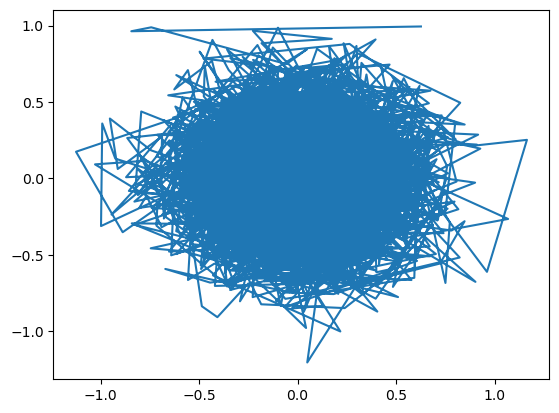

In [204]:
plt.plot(samples[:, 0], samples[:, 1], label='x[0]')
plt.show()